# 원본데이터에 대한 군집 부여 및 silhouette score를 통한 군집 검증, shap value를 통한 군집해석에 주요한 feature추출

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gzip
from IPython.display import display
from tqdm import tqdm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
# matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

import joblib

In [2]:
# 차원축소하지 않은 원본 테이블과 군집라벨 테이블 불러오기
shap_user_log = pd.read_csv('../preprocessed/5_1_forcluster_final2.csv')
hdbscan_case1=pd.read_csv('../preprocessed/5_3_hdbscan_result.csv')

In [3]:
shap_user_log.shape

(183239, 45)

In [ ]:
shap_user_log.head()

In [ ]:
hdbscan_case1

In [6]:
# 라벨 개수 확인
hdbscan_case1['label'].nunique()

7

In [ ]:
shap_user_log  # hdbscan_case1과 행 일치

In [ ]:
# shap_user_log와 hdbscan_case1의 라벨 합치기 
shap_user_log_cluster=shap_user_log.merge(hdbscan_case1[['user_id','application_id','label']], on=['user_id','application_id'])
shap_user_log_cluster

In [9]:
shap_user_log_cluster.set_index(['user_id','application_id'], inplace=True)

In [10]:
shap_user_log_cluster.shape #label을 더했으니 46 -> 44으로 열개수 변환

(183239, 44)

### 군집별 실루엣 스코어 확인
- 실루엣 스코어
    - -1~1 사이 값을 가짐
    - 1에 가까울수록 근처의 다른 군집과 멀리 떨어져있고, 0에 가까울수록 근처의 다른 군집과 가까운 것 (0.25 이하는 군집에서 제외하는 것이 좋다는 논문 있음)
    - 음수값은 아예 다른 군집에 데이터포인트가 할당된 것. 즉, 잘못 군집화된 것
- 민그리드서치한 각각의 군집화 결과 중에서 뭐가 제일 좋은지 판단하기 위해서 튜닝한 모델별로 실루엣 스코어 확인해야 할 듯함

In [11]:
hdbscan_case1.set_index(['user_id','application_id'], inplace=True)

In [ ]:
hdbscan_case1.head()

In [13]:
# 모든 개별 데이터에 실루엣 계수값 구하기 
from sklearn.metrics import silhouette_samples, silhouette_score
X=hdbscan_case1.iloc[:,:-1]
labels=hdbscan_case1.iloc[:,-1]

score_samples=silhouette_samples(X, labels)
print('score_samples shape:' , score_samples.shape)

score_samples shape: (183239,)


In [ ]:
# shap_user_log_cluster에 개별 데이터별 실루엣 계수 컬럼 추가
shap_user_log_cluster['silhouette_coeff']=score_samples
shap_user_log_cluster.head()

In [ ]:
#각 군집별 원소의 수
num_cluster = shap_user_log_cluster.groupby('label')['silhouette_coeff'].count()
num_cluster

In [15]:
# 각 군집별 평균 실루엣 계수값 구하기
# 실루엣 계수값 바탕으로 어느 군집 제거할 것인지 판단 
shap_user_log_cluster.groupby('label')['silhouette_coeff'].agg('mean')

label
-1   -0.490239
 0    0.777484
 1    0.436327
 2    0.822891
 3    0.823982
 4    0.626241
 5   -0.110133
Name: silhouette_coeff, dtype: float64

#### 실루엣 계수결과 0.25값 이하인 -1번 군집, 8번 군집은 분석에서 제외한다.

### 일부 군집 제거 후 최종결과 확인 및 시각화

In [16]:
# 일부 군집 제거해야 할 경우 아래 코드 돌리기
shap_user_log_cluster_except=shap_user_log_cluster[shap_user_log_cluster['label']!=-1]

In [17]:
shap_user_log_cluster_except=shap_user_log_cluster_except[shap_user_log_cluster_except['label']!=5]

In [18]:
shap_user_log_cluster_except.groupby('label')['silhouette_coeff'].agg('mean')

label
0    0.777484
1    0.436327
2    0.822891
3    0.823982
4    0.626241
Name: silhouette_coeff, dtype: float64

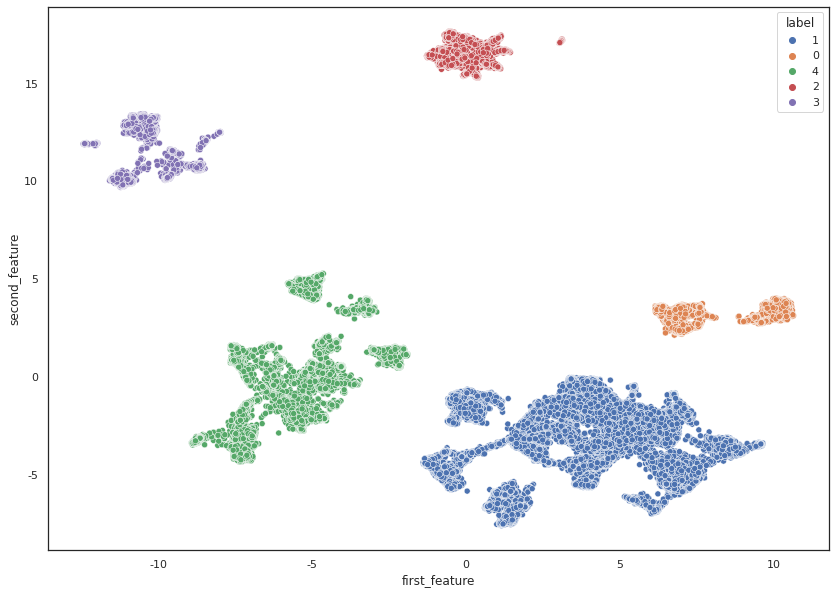

In [48]:
#seaborn의 scatterplot을 통한 시각화
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

hdbscan_case2 = hdbscan_case1.copy()
hdbscan_case2=hdbscan_case2[hdbscan_case2['label']!=-1]
hdbscan_case2=hdbscan_case2[hdbscan_case2['label']!=5]

hdbscan_case2['label'] = hdbscan_case2['label'].astype(str)
ax = sns.scatterplot(x = 'first_feature', y = 'second_feature', hue = 'label', data = hdbscan_case2)
plt.savefig('../output/5_4_hdbscan_scatter_final.png')
#plt.show()

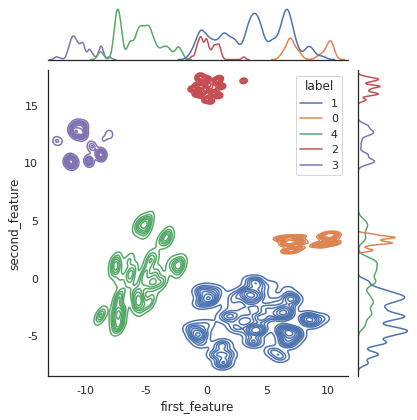

In [47]:
#seaborn의 jointplot을 통한 시각화
ax2 = sns.jointplot(x='first_feature', y='second_feature', hue = 'label', kind="kde", data = hdbscan_case2)
plt.savefig('../output/5_5_hdbscan_jointplot_final.png')

In [19]:
# 최종 군집 데이터프레임 저장
shap_user_log_cluster_except.to_csv('../preprocessed/5_4_cluster_except.csv')

In [ ]:
shap_user_log_cluster_except.head()

### 군집화 결과 shap value로 중요 변수 뽑기

In [ ]:
#!pip install shap

In [21]:
# 기본 sklearn 모듈 임포트
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

# imbalanced data processing 관련 라이브러리 임포트
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

# XGBoost 관련 모듈 임포트
import xgboost as xgb

In [ ]:
# feature, 라벨 분리 - 해당 데이터에만 과적합되어도 상관 없으니 굳이 train, test 나누지 않음
X_exc=shap_user_log_cluster_except.iloc[:,:-2]  
y_exc=shap_user_log_cluster_except.iloc[:,-2]  

# 군집별로 데이터포인트 몇 개씩 들어있는지 확인
print(sorted(Counter(y_exc).items())) 

In [ ]:
shap_user_log_cluster_except.columns

In [ ]:
# XGBoost 모델 학습 
xgb_base=xgb.XGBClassifier(random_state=777, n_jobs=-1, 
                           objective='multi:softmax', num_class=5, eval_metric='merror')  # num_class에 군집 개수 입력
xgb_base.fit(X_exc, y_exc)

# 모델 성능 확인
y_pred=xgb_base.predict(X_exc)
print(classification_report(y_exc, y_pred, digits=5))

In [ ]:
# f1_score 
f1_score(y_exc, y_pred, average='weighted')

In [26]:
# 첫 10개 데이터 결과 확인
print(y_exc[:10].values)
print(y_pred[:10])

[1 1 1 1 0 0 1 1 4 1]
[1 1 1 1 0 0 1 1 4 1]


In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_base)
shap_values = explainer.shap_values(X_exc)

shap.initjs()
shap.summary_plot(shap_values, X_exc)

In [28]:
# shap value 통해서 찾은 중요 변수들 리스트에 담기
# input 달라지면 feature도 달라지니까 위에 그래프 보고 직접 손으로 타이핑 필요!!
cluster_shap_features=['is_applied_Y_last', 'timedelta_max', 
                       'desired_amount_by_income_type_std', 
                       'purpose_by_income_type_BUYCAR', 'income_type', 
                       'purpose_by_income_type_SWITCHLOAN', 
                       'timedelta_min', 'existing_loan_amt', 
                       'CompleteIDCertification_count', 
                       'gender', 'existing_loan_cnt', 
                       'CompleteIDCertification_first', 
                       'GetCreditInfo_count', 
                       'CompleteIDCertification_last', 
                       'credit_score', 'timedelta_std', 
                       'GetCreditInfo_last', 
                       'UseLoanManage_count', 
                       'timedelta_quantile_third', 
                       'insert_hour', 'is_applied']

### 중요 변수에 대해서 군집별 변수 분포 시도

In [ ]:
shap_user_log_cluster_except[cluster_shap_features].info()

In [30]:
# 1행 n열로 kdeplot 그리는 함수
def plot_kde(df, feature_names, ncols, start_idx):
    fig,ax=plt.subplots(nrows=1, ncols=ncols, figsize=(20,5))
    col_names=df[feature_names].columns
    for i in range(ncols):
        sns.kdeplot(data=df, x=col_names[i+start_idx], hue='label', palette='Set2', shade=True, ax=ax[i])
    plt.plot()

In [ ]:
# 1~4번째 feature 분포 시각화 
plot_kde(shap_user_log_cluster_except, cluster_shap_features, ncols=4, start_idx=0)

In [ ]:
# 5~8번째 feature 분포 시각화 
plot_kde(shap_user_log_cluster_except, cluster_shap_features, ncols=4, start_idx=4)

In [ ]:
# 9~12번째 feature 분포 시각화 
plot_kde(shap_user_log_cluster_except, cluster_shap_features, ncols=4, start_idx=8)

In [ ]:
# 13~16번째 feature 분포 시각화 
plot_kde(shap_user_log_cluster_except, cluster_shap_features, ncols=4, start_idx=12)

In [ ]:
# 17~21번째 feature 분포 시각화 (21번째 feature는 is_applied임)
plot_kde(shap_user_log_cluster_except, cluster_shap_features, ncols=5, start_idx=16)